In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
import numpy as np
from pathlib import Path
from torchsummary import summary
torch.set_printoptions(sci_mode=False)

In [24]:
PATH = Path("/home/rob/code/Project/dataset/GTSRB/Training")
torch.set_float32_matmul_precision('high')
LABELS = ["20 km/h"
,"30 km/h"
,"50 km/h"
,"60 km/h"
,"70 km/h"
,"80 km/h"
,"End of speed limit"
,"100 km/h"
,"120 km/h"
,"No passing"
,"No passing for large vehicles"
,"Right of way"
,"Priority road"
,"Yield"
,"Stop"
,"No vehicles"
,"Large vehicles prohibited"
,"No entry"
,"General caution"
,"Dangerous curve to the left"
,"Dangerous curve to the right"
,"Double curve"
,"Bumpy road"
,"Slippery road"
,"Road narrows"
,"Road work"
,"Traffic signals"
,"Pedestrians"
,"Children crossing"
,"Bicycle crossing"
,"Ice warning"
,"Wild animals crossing"
,"End of all speed and passing limits"
,"Turn right ahead"
,"Turn left ahead"
,"Ahead only"
,"Go straight or right"
,"Go straight or left"
,"Keep right"
,"Keep left"
,"Roundabout mandatory"
,"End of no passing"
,"End of no passing by large vehicles"]

In [25]:
_N = 32
batch_size = 256
n_classes = 43
epochs = 30
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [26]:
def get_mean_std():
    transform = transforms.Compose([
    transforms.Resize((_N,_N)),
    transforms.ToTensor(),
    transforms.Grayscale()
    ])
    dataset = torchvision.datasets.ImageFolder(root=PATH,transform=transform)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    mean = 0
    std = 0
    total = 0
    for images,_ in dataloader: # load a batch at a time
        total += 1
        mean  += images.mean()
        std   += images.std()
    std  /= total
    mean /= total
    return mean,std
# get_mean_std() # (tensor(0.3211), tensor(0.2230))

In [27]:
mean = 0.3211
std = 0.2230

def to_image(img): # convert to unormalized form for viewing

    return (img * std + mean).permute(1,2,0).numpy()

normalise = transforms.Normalize(mean, std)
transform = transforms.Compose([
    transforms.Resize((_N,_N)),
    transforms.ToTensor(),
    transforms.Grayscale(),
    normalise
])

In [28]:
dataset = torchvision.datasets.ImageFolder(root=PATH, transform=transform)
loader = torch.utils.data.DataLoader(dataset, 
                                        batch_size=99999, 
                                        num_workers=6,
                                        shuffle=True
                                        )
                                        
images,labels = next(iter(loader))

In [38]:
def get_n_of_each(imgs,labels,n): 
    frequency = np.zeros(43)
    save_imgs = torch.zeros((n*n_classes,1,_N,_N),dtype=torch.float32)
    save_labels = torch.zeros(n*n_classes,dtype=torch.int64)
    counter = 0
    for img,label in zip(imgs,labels):
        if frequency[label] >= n:
            continue
        frequency[label] += 1
        save_imgs[counter] = img
        save_labels[counter] = label
        counter += 1
    print(frequency)
    return save_imgs,save_labels
    
x,y = get_n_of_each(images,labels,10)

[10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10.]


End of no passing


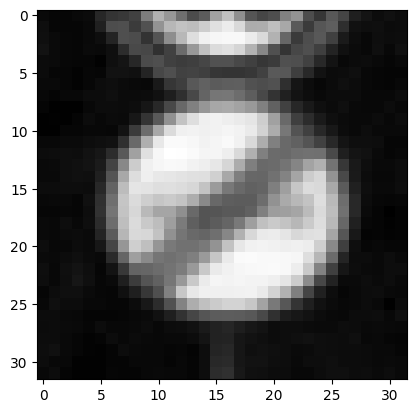

In [43]:
plt.imshow(to_image(x[15]),cmap="grey")
print(LABELS[y[15]])

In [6]:
dataset = torchvision.datasets.ImageFolder(root=PATH, transform=transform)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8,0.2])
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size, 
                                           num_workers=6,
                                           shuffle=True
                                           )
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=batch_size, 
                                          num_workers=6,
                                          shuffle=False
                                          )

torch.Size([256, 1, 32, 32])
Ahead only


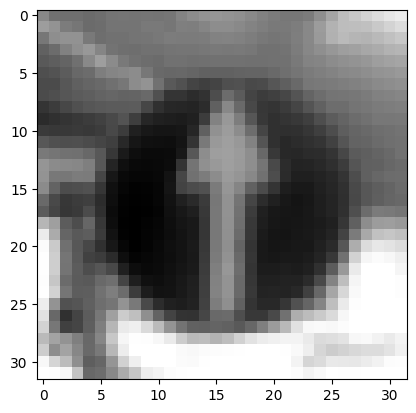

In [ ]:
for img,label in train_loader:
    print(img.shape)
    img = to_image(img[0])

    plt.imshow(img,cmap="grey")
    print(LABELS[label[0]])
    break

In [8]:
images = torch.zeros((n_classes,1,_N,_N))

for imgs,lbls in train_loader:
    for img,lbl in zip(imgs,lbls):
        images[lbl] = img

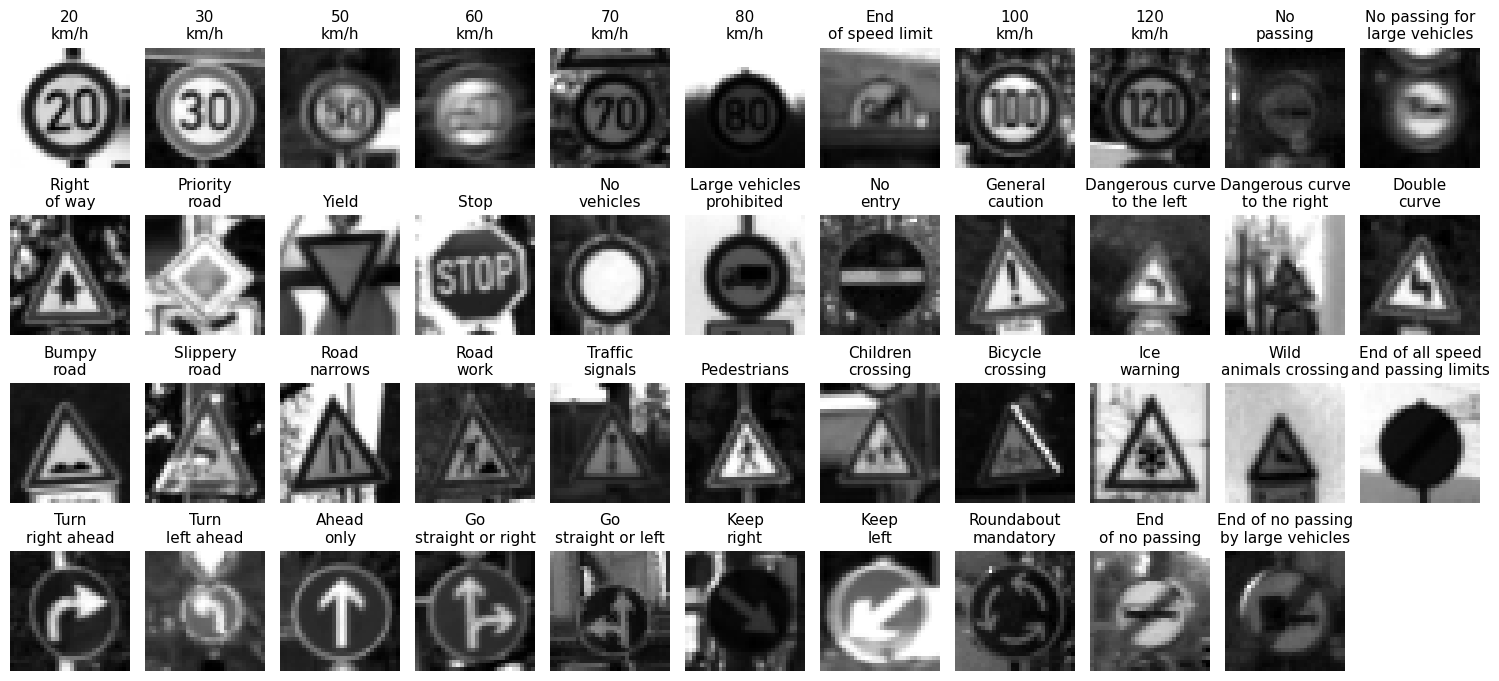

In [9]:
plt.rc('axes', titlesize=11)


plt.figure(figsize=(15,7))

    
for i, img in enumerate(images):
    name = LABELS[i]
    if len(name) > 24:
        name = name[:12] + name[12:].replace(" ","\n",1)
    else:
        name = name.replace(" ","\n",1)
    plt.subplot(4,11, i + 1)
    plt.imshow(to_image(img),cmap="grey")
    plt.title(name)
    plt.axis("off")
plt.tight_layout()

In [10]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        x = torch.zeros((64,1,_N,_N))

        self.activation = torch.nn.functional.relu

        self.pool = torch.nn.AvgPool2d(2,2)

        self.conv1 = torch.nn.Conv2d(1,6,5)
        x = self.pool(self.activation(self.conv1(x)))
        
        self.conv2 = torch.nn.Conv2d(x.shape[1],16,5)
        x = self.pool(self.activation(self.conv2(x)))
        x = torch.flatten(x, start_dim=1)
        self.dense1 = torch.nn.Linear(x.shape[1],120)
        x = self.activation(self.dense1(x))
        self.dense2 = torch.nn.Linear(x.shape[1],80)
        x = self.activation(self.dense2(x))
        self.final = torch.nn.Linear(x.shape[1],n_classes)


    def forward(self,x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        
        x = torch.flatten(x, start_dim=1)

        x = self.activation(self.dense1(x))
        x = self.activation(self.dense2(x))
        x = self.final(x)

        return x
        
model = Model().to(device)
summary(model,(1,32,32),batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [256, 6, 28, 28]             156
         AvgPool2d-2           [256, 6, 14, 14]               0
            Conv2d-3          [256, 16, 10, 10]           2,416
         AvgPool2d-4            [256, 16, 5, 5]               0
            Linear-5                 [256, 120]          48,120
            Linear-6                  [256, 80]           9,680
            Linear-7                  [256, 43]           3,483
Total params: 63,855
Trainable params: 63,855
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 1.00
Forward/backward pass size (MB): 15.87
Params size (MB): 0.24
Estimated Total Size (MB): 17.11
----------------------------------------------------------------


In [11]:
loss_func = torch.nn.CrossEntropyLoss().to(device)
optimiser = torch.optim.Adam(model.parameters())#torch.optim.SGD(model.parameters(),lr=0.01, momentum=0.9)

In [12]:
class EarlyStopping:
    def __init__(self,threshold):
        self.counter = 0
        self.threshold = threshold
        self.min_loss = 999999999
    def should_stop_early(self,current_loss):
        if current_loss < self.min_loss:
            self.counter = 0
            self.min_loss = current_loss
            return False
        self.counter += 1
        return self.counter >= self.threshold


In [13]:
def train(model,loss_func,optimiser,epochs):
    early = EarlyStopping(5)
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimiser.zero_grad()
            preds = model(images)
            loss = loss_func(preds, labels)
            loss.backward()
            optimiser.step()
            total_loss += loss.item()
        validation_loss = test_performance(model,loss_func)
        print(f"Epoch {epoch+1} --- Training Loss {total_loss / len(train_loader):.3f} --- Validation Loss {validation_loss:.3f}")
        if early.should_stop_early(validation_loss):
            print("Early stopping")
            break
        
def test_performance(model,loss_func):
    loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            preds = model(images)
            loss += loss_func(preds,labels).item()
    return loss / len(test_loader)

In [12]:
epochs = 100
train(model,loss_func,optimiser,epochs)

Epoch 1 --- Training Loss 2.872 --- Validation Loss 1.701
Epoch 2 --- Training Loss 1.111 --- Validation Loss 0.772
Epoch 3 --- Training Loss 0.632 --- Validation Loss 0.525
Epoch 4 --- Training Loss 0.461 --- Validation Loss 0.403
Epoch 5 --- Training Loss 0.361 --- Validation Loss 0.323
Epoch 6 --- Training Loss 0.293 --- Validation Loss 0.287
Epoch 7 --- Training Loss 0.242 --- Validation Loss 0.231
Epoch 8 --- Training Loss 0.207 --- Validation Loss 0.208
Epoch 9 --- Training Loss 0.176 --- Validation Loss 0.193
Epoch 10 --- Training Loss 0.153 --- Validation Loss 0.162
Epoch 11 --- Training Loss 0.133 --- Validation Loss 0.154
Epoch 12 --- Training Loss 0.122 --- Validation Loss 0.147
Epoch 13 --- Training Loss 0.105 --- Validation Loss 0.128
Epoch 14 --- Training Loss 0.091 --- Validation Loss 0.124
Epoch 15 --- Training Loss 0.076 --- Validation Loss 0.118
Epoch 16 --- Training Loss 0.071 --- Validation Loss 0.103
Epoch 17 --- Training Loss 0.063 --- Validation Loss 0.110
Epoch 

In [17]:
model = Model().to(device)
model.load_state_dict(torch.load("models/base_epsilon_0.pth"))
evaluate(model)

RuntimeError: Error(s) in loading state_dict for Model:
	size mismatch for dense1.weight: copying a param with shape torch.Size([128, 400]) from checkpoint, the shape in current model is torch.Size([120, 400]).
	size mismatch for dense1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([120]).
	size mismatch for dense2.weight: copying a param with shape torch.Size([64, 128]) from checkpoint, the shape in current model is torch.Size([80, 120]).
	size mismatch for dense2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([80]).
	size mismatch for final.weight: copying a param with shape torch.Size([43, 64]) from checkpoint, the shape in current model is torch.Size([43, 80]).

In [15]:
def evaluate(model):
    predictions = []
    labels = []
    with torch.no_grad():
        for images,lbls in test_loader:
            labels.extend(lbls.numpy())
            
            images = images.to(device)
            preds = model(images)
            predictions.extend(preds.cpu().numpy())
            
    labels = np.array(labels)
    predictions = np.array(predictions)
    pred_class = np.argmax(predictions,axis=1)
    precision = precision_score(labels, pred_class, average="weighted")
    recall = recall_score(labels, pred_class, average="weighted")
    f1 = f1_score(labels, pred_class, average="weighted")
    print(f'Precision (macro): {precision:.4f}')
    print(f'Recall (macro): {recall:.4f}')
    print(f'F1-score (macro): {f1:.4f}')
evaluate(model)

Precision (macro): 0.0021
Recall (macro): 0.0341
F1-score (macro): 0.0038


/home/rob/code/Project/pytorchenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [14]:
@torch.compile
def pgd_attack(model,images,labels,loss_func,epsilon,iterations,decay_rate,learning_rate,momentum_decay):
    
    adversarial = denormalise(images)
    lower_bound = adversarial - epsilon
    upper_bound = adversarial + epsilon
    
    decay = torch.logspace(decay_rate,1,iterations,2)
    decay = decay / decay[0]
    decay *= learning_rate
    
    momentum = torch.zeros(images.shape).to(device)

    for alpha in decay:
        normalised = normalise(adversarial)
        normalised.requires_grad = True
        model.zero_grad()
        pred = model(normalised)
        loss = loss_func(pred,labels)
        #print(loss.item())
        loss.backward()
        # TODO - Edit Learning Rate / Apply Adam Optimiser
        perturbations = torch.sign(normalised.grad.data)
        
        adversarial += (perturbations + momentum) * alpha

        momentum = momentum * momentum_decay + (1 - momentum_decay) * perturbations

        adversarial = torch.clip(adversarial,lower_bound, upper_bound)
        adversarial = torch.clip(adversarial,0,1)

    return normalise(adversarial)



normalise.to(device)

@torch.compile
def denormalise(images):
    return images * std + mean




In [15]:
def pgd_grid_search(results):
    epsilon = 10 / 255
    iterations = 40
    decay_rates = [6,7,8,9]#[2.0,3.0,5.0,10.0,15.0]
    learning_rates = [30 / 255,35 / 255,40 / 255]
    betas = [.8]
    
    for decay_rate in decay_rates:
        for learning_rate in learning_rates:
            for beta in betas:
                total_loss = 0
                for img,lbl in train_loader:
                    img, lbl = img.to(device), lbl.to(device)
                    
                    adv = pgd_attack(model,img,lbl,loss_func,epsilon,iterations,decay_rate,learning_rate,beta)
                    pred = model(adv)
                    total_loss += loss_func(pred,lbl).item()
                to_add = (decay_rate,learning_rate,beta,total_loss)
                results.append(to_add)
                print(to_add)
    return results
                
res = []
#pgd_grid_search(res)

In [16]:
abcd = sorted(res,key=lambda x : x[3],reverse=True)
# Decay rate, learning rate, beta 6, 40.0, 0.8
list(map(lambda x : (x[0],x[1] * 255,*x[2:]),abcd))

[]

In [26]:
@torch.compile
def base_pgd(model,images,labels,loss_func,epsilon,iterations,learning_rate):
    
    adversarial = denormalise(images)
    lower_bound = adversarial - epsilon
    upper_bound = adversarial + epsilon

    for _ in range(iterations):
        normalised = normalise(adversarial)
        normalised.requires_grad = True
        model.zero_grad()
        pred = model(normalised)
        loss = loss_func(pred,labels)
        #print(loss.item())
        loss.backward()
        # TODO - Edit Learning Rate / Apply Adam Optimiser
        perturbations = torch.sign(normalised.grad.data)
        
        adversarial += (perturbations) * learning_rate

        adversarial = torch.clip(adversarial,lower_bound, upper_bound)
        adversarial = torch.clip(adversarial,0,1)

    return normalise(adversarial)


In [34]:
# I want to compare FGSM performance vs good PGD!!!
total_loss = 0
for img,lbl in test_loader:
    img, lbl = img.to(device), lbl.to(device)
    iterations = 1
    epsilon = 10 / 255
    adv = base_pgd(model,img,lbl,loss_func,epsilon,iterations,epsilon)
    pred = model(adv)
    total_loss += loss_func(pred,lbl).item()
print(total_loss)

624.8246936798096


In [39]:
# I want to compare FGSM performance vs good PGD!!!
total_loss = 0
for img,lbl in test_loader:
    img, lbl = img.to(device), lbl.to(device)
    learning_rate = 5 / 255
    iterations = 40
    epsilon = 10 / 255
    adv = base_pgd(model,img,lbl,loss_func,epsilon,iterations,learning_rate)
    pred = model(adv)
    total_loss += loss_func(pred,lbl).item()
print(total_loss)

1080.359281539917


In [40]:
total_loss = 0
for img,lbl in test_loader:
    img, lbl = img.to(device), lbl.to(device)
    decay_rate = 6
    learning_rate = 40 / 255
    momentum_decay = 0.8
    iterations = 40
    epsilon = 10 / 255
    adv = pgd_attack(model,img,lbl,loss_func,epsilon,iterations,decay_rate,learning_rate,momentum_decay)
    pred = model(adv)
    total_loss += loss_func(pred,lbl).item()
print(total_loss)

1190.4263648986816


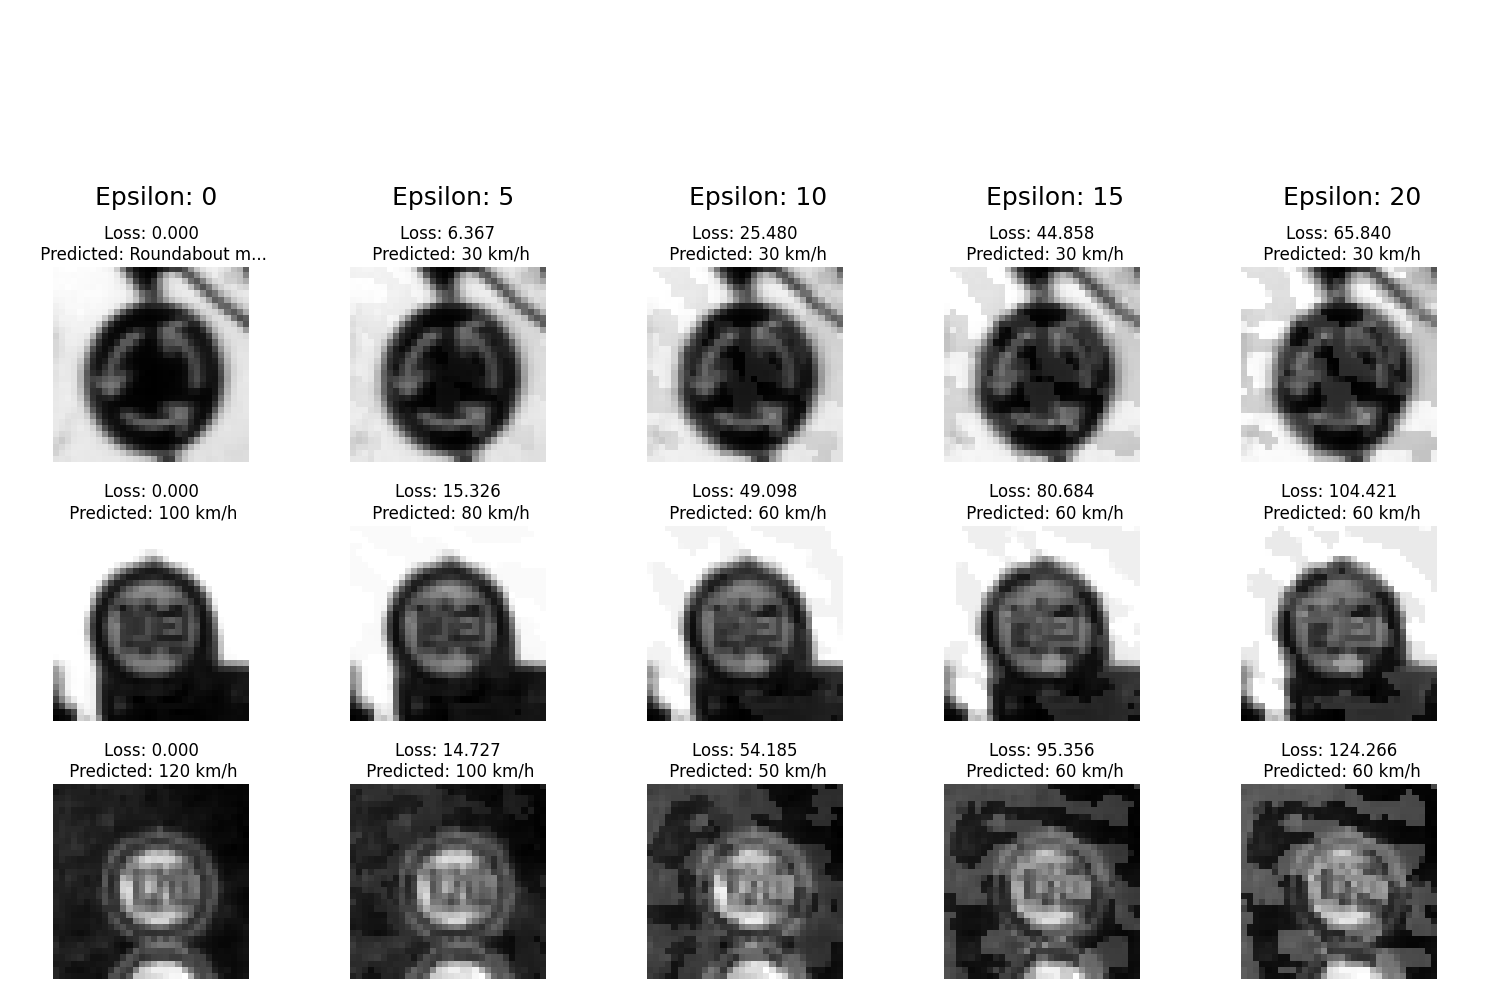

In [19]:
def adversarial_test(model):
    for img,lbl in test_loader:
        img = img.to(device)
        lbl = lbl.to(device)
        rows = 4
        columns = 5
        decay_rate = 6
        learning_rate = 40 / 255
        momentum_decay = 0.8
        iterations = 40
        epsilon = 0.078
        plt.figure(figsize=(15, 10))
        multiplier = 5
        for j in range(columns):
            epsilon = j * multiplier
            plt.subplot(rows, columns, j + 1)
            plt.axis("off")
            plt.text(0.3, 0, f"Epsilon: {epsilon}", fontsize=18)

            

        for j in range(columns):
            epsilon = j * multiplier / 255
            adv = pgd_attack(model,img,lbl,loss_func,epsilon,iterations,decay_rate,learning_rate,momentum_decay)
            for i in range(1,rows):
                plt.subplot(rows, columns, i * columns + j + 1)
                pred = model(adv[i].reshape(1,1,_N,_N))
                loss = loss_func(pred,lbl[i].reshape(1)).data
                pred_class = LABELS[torch.argmax(pred)]
                pred_class = pred_class[:12] + "..." if len(pred_class) > 12 else pred_class
                plt.imshow(to_image(adv[i].cpu()),cmap="grey")
                plt.title(f"Loss: {loss:.3f}\n Predicted: {pred_class}")
                plt.axis("off")
        plt.tight_layout()
        plt.show()
        # Gets errors for images being out of 0-1 range, probably floating point inaccuracy
        break
adversarial_test(model)

In [29]:
def adversarial_training(model,loss_func,optimiser,epochs,epsilon,iterations,decay_rate,learning_rate,momentum_decay):
    early = EarlyStopping(8)
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            images = torch.cat((images,
                pgd_attack(model,images,labels,loss_func,epsilon,iterations,decay_rate,learning_rate,momentum_decay)
                ))
            labels = torch.cat((labels,labels))

            optimiser.zero_grad()
            preds = model(images)
            loss = loss_func(preds, labels)
            loss.backward()
            optimiser.step()
            total_loss += loss.item()
        validation_loss = test_performance(model,loss_func)
        print(f"Epoch {epoch+1} --- Training Loss {total_loss / len(train_loader):.3f} --- Validation Loss {validation_loss:.3f}")
        if early.should_stop_early(validation_loss):
            print("Early stopping")
            break


In [30]:
adversarial_model = Model().to(device)
adv_optimiser = torch.optim.SGD(adversarial_model.parameters(),lr=0.01, momentum=0.9)

In [32]:
abc = Model().to(device)
abc.load_state_dict(torch.load("models/adam_model.pth"))
evaluate(abc)

Precision (macro): 0.9332
Recall (macro): 0.9273
F1-score (macro): 0.9278


In [33]:
abc = Model().to(device)
abc.load_state_dict(torch.load("models/adamw_model.pth"))
evaluate(abc)

Precision (macro): 0.9202
Recall (macro): 0.9036
F1-score (macro): 0.9070


In [34]:
abc = Model().to(device)
abc.load_state_dict(torch.load("models/sgd_model.pth"))
evaluate(abc)

Precision (macro): 0.9346
Recall (macro): 0.9246
F1-score (macro): 0.9263


In [45]:
decay_rate = 6
learning_rate = 40 / 255
momentum_decay = 0.8
iterations = 40
epsilon = 10 / 255
epochs = 100
adversarial_training(adversarial_model,loss_func,adv_optimiser,epochs,epsilon,iterations,decay_rate,learning_rate,momentum_decay)

Epoch 1 --- Training Loss 3.626 --- Validation Loss 3.408
Epoch 2 --- Training Loss 3.364 --- Validation Loss 3.079
Epoch 3 --- Training Loss 2.895 --- Validation Loss 2.194
Epoch 4 --- Training Loss 2.353 --- Validation Loss 1.682
Epoch 5 --- Training Loss 2.065 --- Validation Loss 1.405
Epoch 6 --- Training Loss 1.917 --- Validation Loss 1.270
Epoch 7 --- Training Loss 1.818 --- Validation Loss 1.156
Epoch 8 --- Training Loss 1.745 --- Validation Loss 1.103
Epoch 9 --- Training Loss 1.690 --- Validation Loss 1.024
Epoch 10 --- Training Loss 1.630 --- Validation Loss 0.987
Epoch 11 --- Training Loss 1.589 --- Validation Loss 0.950
Epoch 12 --- Training Loss 1.546 --- Validation Loss 0.903
Epoch 13 --- Training Loss 1.507 --- Validation Loss 0.855
Epoch 14 --- Training Loss 1.478 --- Validation Loss 0.840
Epoch 15 --- Training Loss 1.451 --- Validation Loss 0.823
Epoch 16 --- Training Loss 1.417 --- Validation Loss 0.758
Epoch 17 --- Training Loss 1.398 --- Validation Loss 0.766
Epoch 

# I WANT TO TEST SGD, ADAM, ADAMW FOR ADVERSARIAL TRAINING

In [48]:
torch.save(adversarial_model.state_dict(),f"models/sgd_model.pth")

In [49]:
evaluate(adversarial_model)

Precision (macro): 0.9269
Recall (macro): 0.9177
F1-score (macro): 0.9191


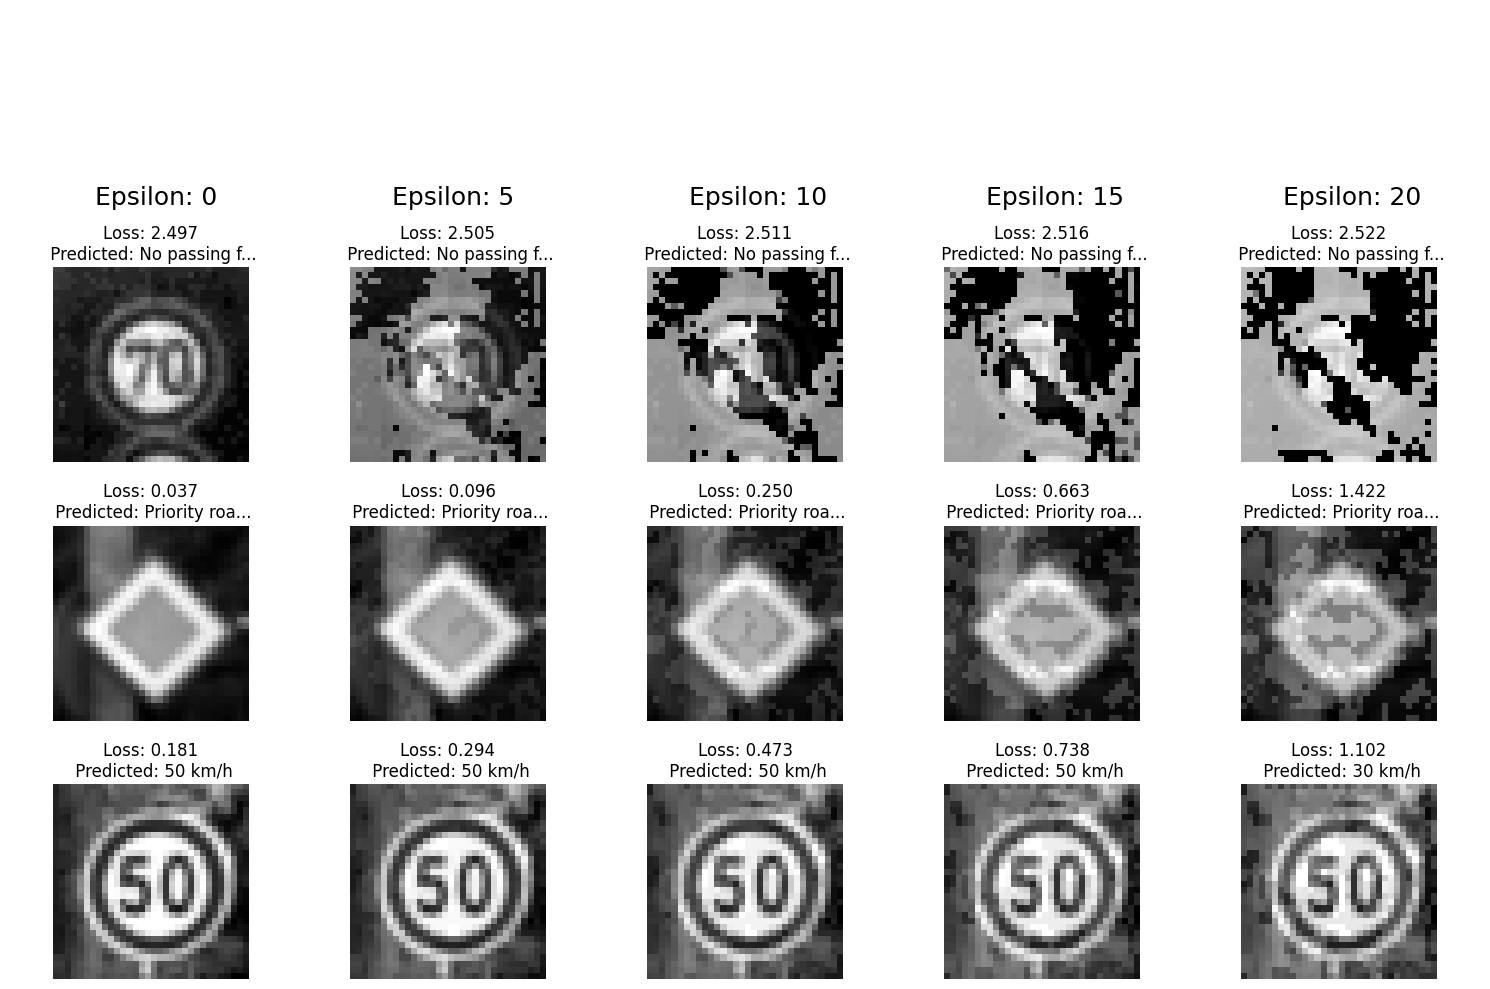

In [ ]:
adversarial_test(adversarial_model)

In [78]:
torch.save(adversarial_model.state_dict(),f"models/adversarial_model_grey_{epsilon*255}.pth")